# Data

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def plot_1d_intervals_comparison(
    X_test,
    uncal_interval,                  # (n_lower, n_upper)
    cp_intervals,                    # (cp_lower, cp_upper)
    true_solution,                   # array OR callable f(X_test)
    uncal_interval_label="Before CP",
    cal_interval_label="After CP",
    t_train=None,
    y_train=None,
    title="PINN Prediction with Conformal & Naïve Intervals",
    figsize=(5.5, 5),
    colors=None,                     # optional dict to override colors by key
    alpha_cp=0.7,
    alpha_naive=1.0,
    dot_size=12,
    dot_edge_size=0.7,

):
    """
    Matches the styling/semantics of the plotting script:
      - CP-band mean is drawn as dashed prediction line
      - Legend at lower center with compact handles
      - Labeling uses x / u(x), fontsize=14, ylabel rotation=0
      - Same color palette and scatter edge styling
    """

    # --- default palette (same constants as your script) ---
    palette = {
        "COL_CP":   "#f7c5c8",
        "COL_MEAN": "#b13c32",
        "COL_NAIV": "#a3c3ea",
        "COL_TRUE": "#222222",
        "COL_SCAT": "#f6d09f",
        "COL_EDGE": "#222222",
    }
    if colors:
        palette.update(colors)
    COL_NAIV = palette["COL_NAIV"]
    COL_MEAN = palette["COL_MEAN"]
    COL_CP   = palette["COL_CP"]
    COL_TRUE = palette["COL_TRUE"]
    COL_SCAT = palette["COL_SCAT"]
    COL_EDGE = palette["COL_EDGE"]

    # --- evaluate truth if callable ---
    if callable(true_solution):
        true_vals = np.asarray(true_solution(X_test)).ravel()
    else:
        true_vals = np.asarray(true_solution).ravel()

    # --- to 1D arrays ---
    x = np.asarray(X_test).ravel()
    n_lower, n_upper = [np.asarray(a).ravel() for a in uncal_interval]
    cp_lower, cp_upper = [np.asarray(a).ravel() for a in cp_intervals]

    # CP mean (to match your script)
    pred_mean = (cp_lower + cp_upper) / 2.0

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # wide -> narrow bands first for nicer layering
    ax.fill_between(x, n_lower, n_upper, color=COL_NAIV, alpha=alpha_naive,
                    label=uncal_interval_label, zorder=1)
    ax.fill_between(x, cp_lower, cp_upper, color=COL_CP, alpha=alpha_cp,
                    label=cal_interval_label, zorder=2)

    # mean + truth
    ax.plot(x, pred_mean, ls="--", lw=2.0, color=COL_MEAN,
            label=r"Prediction", zorder=4)
    ax.plot(x, true_vals, lw=2.4, color=COL_TRUE,
            label=r"True", zorder=3)

    # training data (optional)
    if t_train is not None and y_train is not None:
        ax.scatter(np.asarray(t_train).ravel(), np.asarray(y_train).ravel(),
                   s=dot_size, facecolor=COL_SCAT, edgecolors=COL_EDGE,
                   linewidth=dot_edge_size, label="Data", zorder=5)

    # labels to match script
    ax.set_xlabel(r"$x$", fontsize=13)
    ax.set_ylabel(r"$u$", fontsize=13, rotation=90)

    # layout/styling to match script
    ax.margins(x=0)
    ax.legend(loc="upper right", handlelength=1.6, borderpad=0.6)
    fig.tight_layout()

    return fig, ax


Using device: cpu
Using device: cpu


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


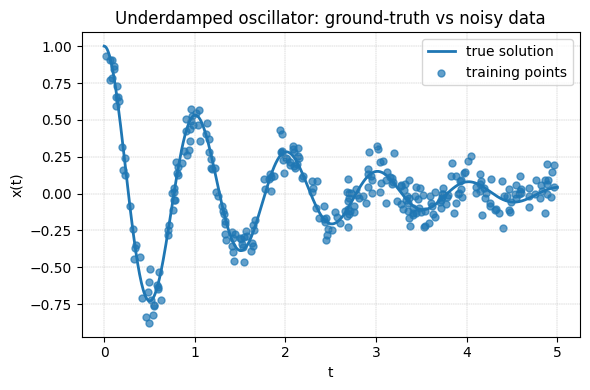

In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from utils_tools.utils_tuning import save_plot

torch.set_num_threads(4)
seed = 113
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.1                       # damping ratio
ω      = 2 * math.pi * 1.0          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 200

data_noise = 0.08
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(1000, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(150, data_noise)
(X_vis, Y_vis) = pde.data_generation(400, data_noise)

# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)

# Dense grid for nice plotting
grid_test = torch.linspace(*domain, 800).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

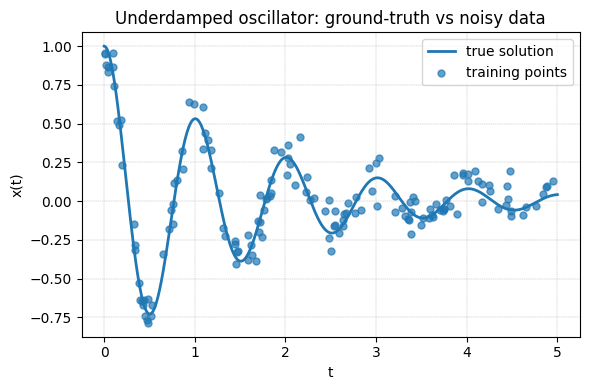

In [3]:
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_calibration,
    Y_train   = Y_calibration,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [4]:
import torch

def add_heteroscedastic_noise_islands(
    X, Y_clean,
    *,
    centers=(1, 2, 3),
    widths=(0.2, 0.2, 0.2),
    bump=0.3,
    baseline=0.0,
    seed=None,
    return_sigma=False,
    return_indices=True
):
    """
    Add heteroscedastic Gaussian noise in local 'islands' (zero outside [c-w, c+w]).

    Returns (depending on flags, in this exact order):
        noisy_idx (LongTensor, 1D)  if return_indices=True
        Y_noisy   (Tensor, like Y_clean)
        sigma     (Tensor, like X)  if return_sigma=True
    """
    assert X.ndim == 2 and X.shape[1] == 1, "X must be (N,1)"
    assert X.device == Y_clean.device, "X and Y_clean must be on the same device"
    device = X.device

    x = X
    sigma = torch.full_like(x, fill_value=baseline)
    inside_mask = torch.zeros_like(x, dtype=torch.bool)

    for c, w in zip(centers, widths):
        phi = torch.exp(-0.5 * ((x - c) / (w + 1e-12))**2)
        box = (x >= c - w) & (x <= c + w)     # hard cutoff
        phi = phi * box
        sigma = sigma + bump * phi
        inside_mask |= box

    if seed is not None:
        torch.manual_seed(int(seed))

    z = torch.randn_like(Y_clean)
    Y_noisy = Y_clean + sigma * z

    if return_indices:
        noisy_idx = torch.nonzero(inside_mask.squeeze(-1), as_tuple=True)[0].to(device=device, dtype=torch.long)

    if return_sigma and return_indices:
        return noisy_idx, Y_noisy, sigma
    elif return_sigma:
        return Y_noisy, sigma
    elif return_indices:
        return noisy_idx, Y_noisy
    else:
        return Y_noisy


In [5]:
# True outputs without noise
Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()
Y_vis_clean   = Y_vis.clone()

# Add heteroscedastic noise
id_train, Y_train        = add_heteroscedastic_noise_islands(X_train, Y_train_clean)
id_test, Y_test         = add_heteroscedastic_noise_islands(X_test,  Y_test_clean)
id_calibration, Y_calibration  = add_heteroscedastic_noise_islands(X_calibration, Y_cal_clean)
id_vis, Y_vis  = add_heteroscedastic_noise_islands(X_vis, Y_vis_clean)


In [6]:
# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
save_plot(
    plot_truth_and_samples_1D,
    save_dir="Adaptive_scaled_CP",
    prefix="heteroscedasticity_data"
)(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

<Figure size 640x480 with 0 Axes>

# Training Base Model

In [7]:
# UQ Model
from utils_uqmd.utils_uq_distance import DistanceUQPINN

model_args = {
    "pde_class":pde,
    "input_dim":1,
    "hidden_dims":[16, 32, 64, 128, 128, 64, 32, 16],
    "output_dim":1,
}

uqmodel = DistanceUQPINN(**model_args)
alpha = 0.05
raw_heuristic = "feature"

# Fit the data
fit_args = dict(coloc_pt_num=200, X_train=X_train, Y_train=Y_train)
fit_kwargs_grid = dict(
    epochs=20000,
    λ_pde= 1.0, λ_ic=10.0, λ_data=3.0,
    lr=1e-3, stop_schedule=40000
)
print(f"\n[🟠] Training...")
baseline_loss_dict = uqmodel.fit(**fit_args, **fit_kwargs_grid)




[🟠] Training...
ep     1 | L=1.51e+02 | lr=1.0e-03
ep   500 | L=8.98e+00 | lr=1.0e-03
ep  1000 | L=3.93e+00 | lr=1.0e-03
ep  1500 | L=2.79e+00 | lr=1.0e-03
ep  2000 | L=1.93e+00 | lr=1.0e-03
ep  2500 | L=1.93e+00 | lr=1.0e-03
ep  3000 | L=1.36e+00 | lr=1.0e-03
ep  3500 | L=1.17e+00 | lr=1.0e-03
ep  4000 | L=1.03e+00 | lr=1.0e-03
ep  4500 | L=9.08e-01 | lr=1.0e-03
ep  5000 | L=5.12e-01 | lr=1.0e-03
ep  5500 | L=5.15e-01 | lr=7.0e-04
ep  6000 | L=5.83e-01 | lr=7.0e-04
ep  6500 | L=3.80e-01 | lr=7.0e-04
ep  7000 | L=3.77e-01 | lr=7.0e-04
ep  7500 | L=4.03e-01 | lr=7.0e-04
ep  8000 | L=2.72e-01 | lr=7.0e-04
ep  8500 | L=2.43e-01 | lr=7.0e-04
ep  9000 | L=2.51e-01 | lr=7.0e-04
ep  9500 | L=1.64e-01 | lr=7.0e-04
ep 10000 | L=2.01e-01 | lr=7.0e-04
ep 10500 | L=1.68e-01 | lr=4.9e-04
ep 11000 | L=1.58e-01 | lr=4.9e-04
ep 11500 | L=1.65e-01 | lr=4.9e-04
ep 12000 | L=1.63e-01 | lr=4.9e-04
ep 12500 | L=1.28e-01 | lr=4.9e-04
ep 13000 | L=1.51e-01 | lr=4.9e-04
ep 13500 | L=1.03e-01 | lr=4.9e-04
ep 

In [8]:
# Model Inferencing
baseline_pred_kwargs = dict(n_samples=100, heuristic_u=raw_heuristic)
print(f"\n[🟠] Base Model Inferencing...")
cp_uncal_predset = uqmodel.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


[🟠] Base Model Inferencing...


# Adaptive Scaled CP

In [9]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP, adaptive_cp_test_uncertainties_grid
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 128, 128, 64, 32, 16),
    "conf_nn_lr":1e-4,
    "conf_nn_epochs":20000
}
adap_cp = AdaptiveCP(uqmodel, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=20
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


In [10]:

save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=adp_cp_cal_predset,
    uncal_interval_label="Naive UQ Band",
    cal_interval_label="Adaptive Scaled CP Band",
    true_solution=pde.true_solution,            # pass the function
    t_train=X_vis,
    y_train=Y_vis,
    title="0.05-Alpha Level Adaptive Scaled Conformal Calibrated Prediction"
)

<Figure size 640x480 with 0 Axes>

# Normal Scaled CP

In [11]:
# Normal CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":raw_heuristic,  # Change this based on cp
        "k":20
}
from utils_uqmd.utils_uq_cp import CP
cp_model = CP(uqmodel)
cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=grid_test,
            **cp_pred_kwargs
            )

In [12]:
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="cp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution, 
    uncal_interval_label="Naive UQ Band",
    cal_interval_label="Scaled CP Band",
    t_train=X_vis,
    y_train=Y_vis,
    title="0.05-Alpha Level Scaled Conformal Calibrated Prediction"
)

<Figure size 640x480 with 0 Axes>

# Visual Comparison: Scaled CP v.s. Adaptive Scaled CP

In [13]:
id_vis, Y_test, sigma_test = add_heteroscedastic_noise_islands(X_test, Y_test, return_sigma=True)

import torch, numpy as np

def as_long_idx(idx, device):
    if isinstance(idx, np.ndarray):
        return torch.as_tensor(idx, dtype=torch.long, device=device)
    elif not torch.is_tensor(idx):
        return torch.as_tensor(idx, dtype=torch.long, device=device)
    else:
        return idx.to(device=device, dtype=torch.long)

idx = as_long_idx(id_test, X_test.device)

# 1a) in-range, 1-D, non-empty
assert idx.ndim == 1 and idx.numel() > 0, "[idx] empty or not 1-D"
assert (0 <= idx.min()) and (idx.max() < X_test.shape[0]), "[idx] out of range"

# 1b) duplicates?
num_dup = idx.numel() - torch.unique(idx).numel()
print(f"[idx] duplicates = {num_dup}")

# 1c) monotone (only for info; non-monotone is OK)
inversions = int((torch.diff(X_test[idx].view(-1)) < 0).sum().item())
print(f"[idx] inversions (non-monotone count) = {inversions}")


[idx] duplicates = 0
[idx] inversions (non-monotone count) = 124


In [14]:
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_cal_predset,
    cp_intervals=adp_cp_cal_predset,
    true_solution=pde.true_solution,            
    uncal_interval_label="CP",
    cal_interval_label="Local CP",
    t_train=X_vis,
    y_train=Y_vis,
)

<Figure size 640x480 with 0 Axes>

# Test model's coverage in large noise area

In [15]:
# utils_tools/utils_cp_diagnostics.py
import torch
import numpy as np
import pandas as pd
from utils_tools.utils_result_metrics import _coverage, _sharpness, _interval_score

def _as_long_idx(idx, device):
    if isinstance(idx, np.ndarray):
        idx = torch.as_tensor(idx, dtype=torch.long, device=device)
    elif not torch.is_tensor(idx):
        idx = torch.as_tensor(idx, dtype=torch.long, device=device)
    else:
        idx = idx.to(device=device, dtype=torch.long)
    return idx

def assert_same_device(*tensors):
    devs = [t.device for t in tensors if torch.is_tensor(t)]
    if len(devs) == 0: return
    assert all(d == devs[0] for d in devs), f"[Device] Mismatched devices: {devs}"

def assert_shapes_match(lower, upper, Y):
    n = Y.shape[0]
    assert lower.shape[0] == n and upper.shape[0] == n, \
        f"[Shapes] lower/upper shapes {lower.shape}, {upper.shape} != Y {Y.shape}"
    # allow (N,) or (N,1)
    if lower.ndim == 2: 
        assert lower.shape[1] in (1, Y.shape[1] if Y.ndim==2 else 1), \
            f"[Shapes] Unexpected second dim: lower={lower.shape}, upper={upper.shape}, Y={Y.shape}"
    if upper.ndim == 2:
        assert upper.shape[1] in (1, Y.shape[1] if Y.ndim==2 else 1), \
            f"[Shapes] Unexpected second dim: lower={lower.shape}, upper={upper.shape}, Y={Y.shape}"

def check_indices_against_X(X_test, idx):
    # basic sanity on range and duplicates
    assert idx.ndim == 1, "[Index] idx_noisy_test must be 1D"
    assert idx.numel() > 0, "[Index] idx_noisy_test is empty"
    assert idx.min() >= 0 and idx.max() < X_test.shape[0], \
        f"[Index] idx out of range (0..{X_test.shape[0]-1})"
    # (Optional) detect accidental resorting by caller
    # If X is 1D, verify increasing x among selected points
    try:
        x = X_test[idx].detach().cpu().view(-1).numpy()
        if np.all(np.isfinite(x)):
            inversions = np.sum(np.diff(x) < 0)
            if inversions > 0:
                print(f"[Index] Warning: selected X not monotone; potential shuffling (inversions={inversions}).")
    except Exception:
        pass

def check_predict_subset_alignment(uqmodel, alpha, X_test, idx, *,
                                   X_train, Y_train, X_cal, Y_cal,
                                   heuristic_u=None, k=None):
    """
    Verifies that slicing the full prediction equals predicting on the subset directly.
    If they differ, you likely have internal reordering inside uqmodel.predict.
    """
    idx = _as_long_idx(idx, X_test.device)
    # full -> slice
    lo_full, up_full = uqmodel.predict(alpha, X_test,
                                       X_train=X_train, Y_train=Y_train,
                                       X_cal=X_cal,   Y_cal=Y_cal,
                                       heuristic_u=heuristic_u, k=k)
    lo_slice, up_slice = lo_full[idx], up_full[idx]

    # subset direct
    X_sel = X_test[idx]
    lo_sub, up_sub = uqmodel.predict(alpha, X_sel,
                                     X_train=X_train, Y_train=Y_train,
                                     X_cal=X_cal,   Y_cal=Y_cal,
                                     heuristic_u=heuristic_u, k=k)

    # compare
    dl = torch.max(torch.abs(lo_slice - lo_sub)).item()
    du = torch.max(torch.abs(up_slice - up_sub)).item()
    ok = (dl < 1e-7) and (du < 1e-7)
    if not ok:
        print(f"[Predict] Mismatch full-slice vs subset-direct (max |Δ| lower={dl:.3e}, upper={du:.3e}). "
              f"Prefer predicting directly on the subset to avoid ordering issues.")
    return ok, (dl, du)

def summarize_cp_metrics_row(alpha_val, pred_set, Y_eval, _coverage, _sharpness, _interval_score):
    cov = _coverage(pred_set, Y_eval)
    sha = _sharpness(pred_set)
    iscore = _interval_score(pred_set, Y_eval, alpha_val)
    return {"alpha": alpha_val, "coverage": cov, "sharpness": sha, "interval score": iscore}


In [16]:
def _to_1d(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device).reshape(-1)
    return torch.as_tensor(x, dtype=torch.float32, device=device).reshape(-1)

def _normalize_predset_to_1d(lower, upper, device):
    l = _to_1d(lower, device); u = _to_1d(upper, device)
    # ensure lower <= upper
    swap = l > u
    if swap.any():
        l2, u2 = l.clone(), u.clone()
        l2[swap], u2[swap] = u[swap], l[swap]
        l, u = l2, u2
    return l, u

def quick_compare_scaled_vs_local(
    scaled_cp, base_model, alphas,
    X_train, Y_train, X_cal, Y_cal,
    X_test, Y_test, idx_noisy_test,
    *, heuristic_u=None, k=None, predict_on_subset=True,
    conf_nn_hidden_layers=(16, 32, 64, 128, 128, 64, 32, 16), conf_nn_lr=5e-4, conf_nn_epochs=20000,
    seed=1234,                                  # NEW: make runs reproducible
    log_widths=False                            # NEW: optional diagnostics
):
    idx = _as_long_idx(idx_noisy_test, X_test.device)
    Y_sel = Y_test[idx]
    rows = []

    # Reproducibility for q-net training inside AdaptiveCP
    torch.manual_seed(seed); np.random.seed(seed)

    for alpha in alphas:
        a = float(alpha)

        # --- Scaled CP
        if predict_on_subset:
            lo_s, up_s = scaled_cp.predict(a, X_test[idx],
                                           X_train=X_train, Y_train=Y_train,
                                           X_cal=X_cal,   Y_cal=Y_cal,
                                           heuristic_u=heuristic_u, k=k)
        else:
            lo, up = scaled_cp.predict(a, X_test,
                                       X_train=X_train, Y_train=Y_train,
                                       X_cal=X_cal,   Y_cal=Y_cal,
                                       heuristic_u=heuristic_u, k=k)
            lo_s, up_s = lo[idx], up[idx]

        l_s, u_s = _normalize_predset_to_1d(lo_s, up_s, Y_sel.device)
        y_s = _to_1d(Y_sel, l_s.device)
        assert y_s.numel() == l_s.numel() == u_s.numel(), "[ScaledCP] length mismatch"
        r_s = {
            "alpha": a,
            "coverage": _coverage((l_s, u_s), y_s),
            "sharpness": _sharpness((l_s, u_s)),
            "interval score": _interval_score((l_s, u_s), y_s, a),
            "method": "ScaledCP"
        }
        if log_widths:
            r_s["mean_width"] = (u_s - l_s).mean().item()
        rows.append(r_s)

        # --- LocalScaled (AdaptiveCP) — fresh instance per alpha
        acp = AdaptiveCP(
            model=base_model, alpha=a, heuristic=heuristic_u or "feature",
            conf_nn_hidden_layers=conf_nn_hidden_layers,
            conf_nn_lr=conf_nn_lr, conf_nn_epochs=conf_nn_epochs
        )
        if predict_on_subset:
            lo_l, up_l = acp.predict(a, X_test[idx],
                                     X_train=X_train, Y_train=Y_train,
                                     X_cal=X_cal,   Y_cal=Y_cal,
                                     heuristic_u=heuristic_u, k=k)
        else:
            lo, up = acp.predict(a, X_test,
                                 X_train=X_train, Y_train=Y_train,
                                 X_cal=X_cal,   Y_cal=Y_cal,
                                 heuristic_u=heuristic_u, k=k)
            lo_l, up_l = lo[idx], up[idx]

        l_l, u_l = _normalize_predset_to_1d(lo_l, up_l, Y_sel.device)
        y_l = _to_1d(Y_sel, l_l.device)
        assert y_l.numel() == l_l.numel() == u_l.numel(), "[LocalScaledCP] length mismatch"
        r_l = {
            "alpha": a,
            "coverage": _coverage((l_l, u_l), y_l),
            "sharpness": _sharpness((l_l, u_l)),
            "interval score": _interval_score((l_l, u_l), y_l, a),
            "method": "LocalScaledCP"
        }
        if log_widths:
            r_l["mean_width"] = (u_l - l_l).mean().item()
        rows.append(r_l)

    df = pd.DataFrame(rows).sort_values(["alpha", "method"]).reset_index(drop=True)
    return df


In [17]:
from utils_tools.utils_result_metrics import _coverage, _sharpness, _interval_score
id_test, Y_test    = add_heteroscedastic_noise_islands(X_test,  Y_test_clean)
X_cal = X_calibration
Y_cal = Y_calibration
# Ensure devices line up
assert_same_device(X_train, Y_train, X_cal, Y_cal, X_test, Y_test)


# Basic index sanity
check_indices_against_X(X_test, id_test)

# Verify predict alignment (catch internal reordering)
ok_align, deltas = check_predict_subset_alignment(
    cp_model, 0.05, X_test, id_test,
    X_train=X_train, Y_train=Y_train, X_cal=X_cal, Y_cal=Y_cal,
    heuristic_u="feature", k=20
)
print("[Subset alignment OK]" if ok_align else "[Subset alignment MISMATCH]", deltas)

# (Optional) run a head-to-head table on the noisy subset
df_quick = quick_compare_scaled_vs_local(
    cp_model, uqmodel, [0.05, 0.1],
    X_train, Y_train, X_cal, Y_cal, X_test, Y_test, id_test,
    heuristic_u="feature", k=20, predict_on_subset=True
)
print(df_quick.head())


[Index] Warning: selected X not monotone; potential shuffling (inversions=124).
[Subset alignment OK] (0.0, 0.0)

[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples

[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples
   alpha  coverage  sharpness  interval score         method
0   0.05  0.903226   0.914938        1.436334  LocalScaledCP
1   0.05  0.850806   0.683983        1.712402       ScaledCP
2   0.10  0.842742   0.789760        1.169525  LocalScaledCP
3   0.10  0.689516   0.446357        1.514756       ScaledCP


## Helper function to select out noisy region's data points

In [18]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)


cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

  0%|          | 0/19 [00:00<?, ?it/s]

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:39<11:51, 39.53s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:20<11:29, 40.55s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [02:02<10:58, 41.14s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:45<10:25, 41.71s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [03:26<09:43, 41.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [04:08<08:59, 41.53s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [04:49<08:16, 41.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [05:29<07:33, 41.21s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [06:09<06:48, 40.84s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [06:52<06:12, 41.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [07:34<05:32, 41.60s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [08:16<04:51, 41.59s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [08:57<04:08, 41.39s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [09:37<03:25, 41.04s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [10:17<02:43, 40.84s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [10:57<02:01, 40.64s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [11:37<01:20, 40.43s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [12:18<00:40, 40.41s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [12:57<00:00, 40.91s/it]


In [19]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
import pandas as pd
def plot_dual_expected_vs_empirical(
    df_uncal,
    df_cal,
    *,
    alpha_col="alpha",
    cov_col="coverage",
    title1="Uncalibrated Model",
    title2="Calibrated Model",
    dev_metric="mae",
    main_title="Coverage: Uncalibrated vs Calibrated",
    figsize=(12, 6),
    constrained=True,           # set False if you prefer tight_layout()
    title_pad=14,               # vertical offset for the figure title
    tight_rect=(0, 0, 1, 0.96), # head-room if constrained=False
):
    """
    Side-by-side coverage plots for uncalibrated and calibrated models.

    The subtitle of each panel shows the deviation from ideal calibration
    (MAE / RMSE / max absolute error).

    Parameters
    ----------
    df_uncal, df_cal : pd.DataFrame
        Must contain columns `alpha_col` and `cov_col`.
    dev_metric : {"mae", "rmse", "max"}
        Metric used for the deviation shown under each panel title.
    main_title : str or None
        Figure-level title.  Set None to suppress it.
    constrained : bool
        Use Matplotlib’s constrained-layout engine (recommended).
        If False, the function falls back to tight_layout with `tight_rect`.
    """

    # ------------------------------------------------------------------
    # helpers
    def _prepare(df):
        exp = 1.0 - df[alpha_col]
        emp = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), exp, pd.Series([1.0])],
                             ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), emp, pd.Series([1.0])],
                             ignore_index=True)
        order = exp_full.argsort()
        return exp_full[order].to_numpy(), emp_full[order].to_numpy()

    def _deviation(e, m, how):
        diff = np.abs(m - e)
        if how == "mae":
            return diff.mean()
        if how == "rmse":
            return np.sqrt((diff ** 2).mean())
        if how == "max":
            return diff.max()
        raise ValueError("dev_metric must be 'mae', 'rmse', or 'max'")

    # ------------------------------------------------------------------
    # data + metrics
    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)
    dev1 = _deviation(exp1, emp1, dev_metric)
    dev2 = _deviation(exp2, emp2, dev_metric)

    # ------------------------------------------------------------------
    # figure & axes
    if constrained:
        fig, axes = plt.subplots(1, 2, figsize=figsize,
                                 constrained_layout=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)

    # panel 1 – uncalibrated
    axes[0].plot(exp1, emp1, marker="o", label="Empirical")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[0].set_title(f"{title1}\nDeviation ({dev_metric.upper()}): {dev1:.3f}")
    axes[0].set_xlabel("Expected Coverage  (1 − α)")
    axes[0].set_ylabel("Empirical Coverage")
    axes[0].grid(True)
    axes[0].legend()

    # panel 2 – calibrated
    axes[1].plot(exp2, emp2, marker="o", label="Empirical")
    axes[1].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[1].set_title(f"{title2}\nDeviation ({dev_metric.upper()}): {dev2:.3f}")
    axes[1].set_xlabel("Expected Coverage  (1 − α)")
    axes[1].set_ylabel("Empirical Coverage")
    axes[1].grid(True)
    axes[1].legend()

    # ------------------------------------------------------------------
    # figure-level title and layout finish
    if main_title:
        fig.suptitle(main_title, y=1.1, fontsize=12)

    if not constrained:            # tidy up only if we skipped the CL engine
        fig.tight_layout(rect=tight_rect)

    return fig, axes

save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_cp_coverage_plot_LOCAL"
)(cp_df_local, adap_df_local, title1="Scaled CP", title2="Adaptive Scaled CP", 
  main_title="Coverage Plot of Adaptive Conformal Prediction & Conformal Prediction Across Alpha Levels")

<Figure size 640x480 with 0 Axes>

In [20]:
from utils_tools.utils_result_viz import plot_metrics_table

df1=cp_df_local
df2=adap_df_local
df1_name="CP" 
df2_name="Adaptive CP"
save_plot(
    plot_metrics_table,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_table_LOCAL"
)(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")

Uncal dev:0.19124424652684302
Cal dev:0.029185870928423747


<Figure size 640x480 with 0 Axes>

# Test model's Global coverage

In [21]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)


cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:39<11:47, 39.30s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:18<11:05, 39.16s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:58<10:32, 39.51s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:38<09:55, 39.72s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [03:19<09:21, 40.14s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:59<08:44, 40.33s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [04:40<08:03, 40.28s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [05:19<07:19, 39.96s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [05:59<06:40, 40.04s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [06:40<06:02, 40.25s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [07:21<05:23, 40.40s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [08:00<04:41, 40.18s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [08:34<03:49, 38.29s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [09:07<03:03, 36.62s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [09:40<02:21, 35.44s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [10:12<01:43, 34.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [10:44<01:07, 33.67s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [11:16<00:33, 33.09s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [11:47<00:00, 37.24s/it]


In [22]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
import pandas as pd
def plot_dual_expected_vs_empirical(
    df_uncal,
    df_cal,
    *,
    alpha_col="alpha",
    cov_col="coverage",
    title1="Uncalibrated Model",
    title2="Calibrated Model",
    dev_metric="mae",
    main_title="Coverage: Uncalibrated vs Calibrated",
    figsize=(12, 6),
    constrained=True,           # set False if you prefer tight_layout()
    title_pad=14,               # vertical offset for the figure title
    tight_rect=(0, 0, 1, 0.96), # head-room if constrained=False
):
    """
    Side-by-side coverage plots for uncalibrated and calibrated models.

    The subtitle of each panel shows the deviation from ideal calibration
    (MAE / RMSE / max absolute error).

    Parameters
    ----------
    df_uncal, df_cal : pd.DataFrame
        Must contain columns `alpha_col` and `cov_col`.
    dev_metric : {"mae", "rmse", "max"}
        Metric used for the deviation shown under each panel title.
    main_title : str or None
        Figure-level title.  Set None to suppress it.
    constrained : bool
        Use Matplotlib’s constrained-layout engine (recommended).
        If False, the function falls back to tight_layout with `tight_rect`.
    """

    # ------------------------------------------------------------------
    # helpers
    def _prepare(df):
        exp = 1.0 - df[alpha_col]
        emp = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), exp, pd.Series([1.0])],
                             ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), emp, pd.Series([1.0])],
                             ignore_index=True)
        order = exp_full.argsort()
        return exp_full[order].to_numpy(), emp_full[order].to_numpy()

    def _deviation(e, m, how):
        diff = np.abs(m - e)
        if how == "mae":
            return diff.mean()
        if how == "rmse":
            return np.sqrt((diff ** 2).mean())
        if how == "max":
            return diff.max()
        raise ValueError("dev_metric must be 'mae', 'rmse', or 'max'")

    # ------------------------------------------------------------------
    # data + metrics
    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)
    dev1 = _deviation(exp1, emp1, dev_metric)
    dev2 = _deviation(exp2, emp2, dev_metric)

    # ------------------------------------------------------------------
    # figure & axes
    if constrained:
        fig, axes = plt.subplots(1, 2, figsize=figsize,
                                 constrained_layout=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)

    # panel 1 – uncalibrated
    axes[0].plot(exp1, emp1, marker="o", label="Empirical")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[0].set_title(f"{title1}\nDeviation ({dev_metric.upper()}): {dev1:.3f}")
    axes[0].set_xlabel("Expected Coverage  (1 − α)")
    axes[0].set_ylabel("Empirical Coverage")
    axes[0].grid(True)
    axes[0].legend()

    # panel 2 – calibrated
    axes[1].plot(exp2, emp2, marker="o", label="Empirical")
    axes[1].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[1].set_title(f"{title2}\nDeviation ({dev_metric.upper()}): {dev2:.3f}")
    axes[1].set_xlabel("Expected Coverage  (1 − α)")
    axes[1].set_ylabel("Empirical Coverage")
    axes[1].grid(True)
    axes[1].legend()

    # ------------------------------------------------------------------
    # figure-level title and layout finish
    if main_title:
        fig.suptitle(main_title, y=1.1, fontsize=12)

    if not constrained:            # tidy up only if we skipped the CL engine
        fig.tight_layout(rect=tight_rect)

    return fig, axes

save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_cp_coverage_plot_GLOBAL"
)(cp_df_global, adap_df_global, title1="CP", title2="Adaptive CP", 
  main_title="Coverage Plot of Adaptive Conformal Prediction & Conformal Prediction Across Alpha Levels")

<Figure size 640x480 with 0 Axes>

In [23]:
from utils_tools.utils_result_viz import plot_metrics_table

df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"
save_plot(
    plot_metrics_table,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_table_GLOBAL"
)(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")

Uncal dev:0.015952380285376593
Cal dev:0.017095232249370644


<Figure size 640x480 with 0 Axes>

In [24]:
def plot_coverage_grid_2x2(
    named_pairs,
    *,
    labels=("After CP", "After Local CP"),
    grid_figsize=(15, 7.5),
    suptitle=None,
    model_title_size=22,
):
    """
    named_pairs: list or dict of exactly 4 items like:
        [("Model A", df_uncal_A, df_cal_A), ...]
        OR {"Model A": (df_uncal_A, df_cal_A), ...}
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # --- same prep as in plot_coverage_comparison ---
    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    # normalize input
    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)
    if len(items) != 2:
        raise ValueError("Provide exactly 2 (name, df_uncal, df_cal) pairs.")

    fig, axs = plt.subplots(1, 2, figsize=grid_figsize)

    i = 0
    for ax, (name, df_uncal, df_cal) in zip(axs.ravel(), items):
        # --- begin: copied body of plot_coverage_comparison (minimal version) ---
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)

        # curves + ideal
        ax.plot(exp1, emp1, 'o-', color="#b13c32", markerfacecolor="#ed8076", ms=14, lw=5, label=labels[0])
        ax.plot(exp2, emp2, '*-', color="#3291b1", markerfacecolor="#69b5ef", ms=20, lw=5, label=labels[1])
        ax.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
        i+=1
        if i <= 1:
            # limits & labels
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=18)
            ax.set_ylabel("Empirical Coverage", fontsize=18)
            ax.legend(loc='upper left', fontsize=17)
            # --- end: copied body ---

            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)
        else:
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
            ax.set_ylabel(" ")
            ax.legend(loc='upper left', fontsize=17)
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=18)
            # --- end: copied body ---

            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.tight_layout()

    return fig, axs


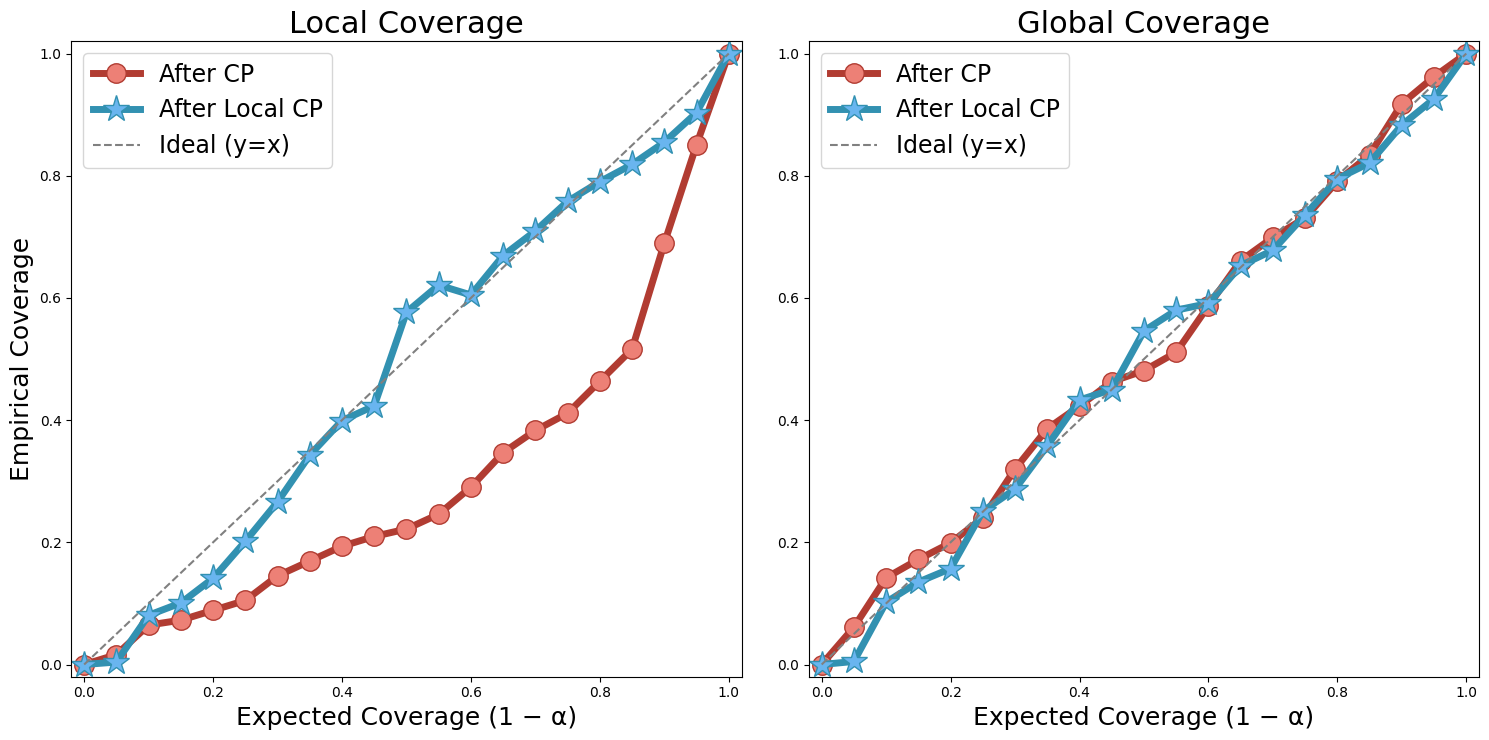

<Figure size 640x480 with 0 Axes>

In [25]:
pairs = [
    ("Local Coverage",    cp_df_local,  adap_df_local),
    ("Global Coverage", cp_df_global,    adap_df_global),
]
fig, axs = plot_coverage_grid_2x2(pairs)

save_plot(
    plot_coverage_grid_2x2,
    save_dir="Adaptive_scaled_CP", prefix="coverage_sets",
)(pairs)

In [26]:
# Compute mean
pred_set_plot = uqmodel.predict(alpha, X_test, 
                            **baseline_pred_kwargs)
pred_mean_plot = (pred_set_plot[0] + pred_set_plot[1])/2

In [27]:
import torch

@torch.no_grad()
def local_noise_max_from_xy(
    X: torch.Tensor,
    Y: torch.Tensor,
    k: int = 15,
    metric: str = "mae",   # 'mae' -> |Yi-Yj|, 'mse' -> (Yi-Yj)^2
):
    """
    Estimate local noise at each X_i as the maximum pairwise target difference
    within its k-NN neighborhood (in X-space), excluding self.

    Args
    ----
    X : (n,d) or (n,) torch tensor
    Y : (n,)  or (n,1) torch tensor
    k : int   number of neighbors (incl. self in search)
    metric : {'mae','mse'}

    Returns
    -------
    local_noise_max : (n,) tensor
        max_j |Yi - Yj| (or squared) over the k-NN of X_i, j != i.
        If k <= 1, returns zeros.
    nn_idx : (n,k) LongTensor
        Indices of the k nearest neighbors for each point (includes self).
    argmax_idx : (n,) LongTensor
        Index (into original dataset) of the neighbor achieving the max for each i.
        For k <= 1, filled with i.
    """
    # normalize shapes
    if X.ndim == 1:
        X = X.unsqueeze(-1)
    Y = Y.reshape(-1)

    n = X.shape[0]
    k = int(max(1, min(k, n)))

    # kNN (Euclidean). nn_idx includes self (distance 0).
    dists = torch.cdist(X, X, p=2)                              # (n, n)
    nn_idx = torch.topk(dists, k=k, dim=1, largest=False).indices  # (n, k)

    # gather neighbor targets and build pairwise diffs
    Y_nei = Y[nn_idx]                                           # (n, k)
    Yi = Y.unsqueeze(1)                                         # (n, 1)
    if metric.lower() == "mse":
        diffs = (Y_nei - Yi).pow(2)
    else:  # 'mae'
        diffs = (Y_nei - Yi).abs()

    # exclude self from the max
    rows = torch.arange(n, device=nn_idx.device).unsqueeze(1)   # (n,1)
    self_mask = nn_idx.eq(rows)                                 # (n,k)
    if k == 1:
        # no neighbors besides self
        local_noise_max = torch.zeros(n, dtype=diffs.dtype, device=diffs.device)
        argmax_idx = rows.squeeze(1)
        return local_noise_max, nn_idx, argmax_idx

    diffs_masked = diffs.masked_fill(self_mask, float("-inf"))
    # max over neighbors
    max_vals, which = torch.max(diffs_masked, dim=1)            # (n,), (n,)
    # map which (position in k) -> original dataset index
    argmax_idx = nn_idx[torch.arange(n, device=nn_idx.device), which]

    # if a row was all -inf (shouldn't happen unless k==1), clamp to 0
    max_vals = torch.where(torch.isinf(max_vals), torch.zeros_like(max_vals), max_vals)

    return max_vals, nn_idx, argmax_idx


In [28]:
# X, Y are torch tensors
local_noise, _, _ = local_noise_max_from_xy(X_test, Y_test, k=5, metric="mae")


In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_local_error_bar(
    X: torch.Tensor,
    local_err: torch.Tensor,
    heuristics: torch.Tensor | None = None,   # optional
    *,
    k: int = 15,
    nbar: int | None = None,
    colors=("#d9534f", "#4287f5"),            # (true, heuristic)
    labels=("True", "Est."),
    bar_width: float = 0.7,                   # base (true) bar width, a bit wider for overlay
    overlay_frac: float = 1.0,               # heuristic width fraction of base bar (0<..<=1)
    figsize=(5, 5),
    title="Local error across grid",
    tick_count: int = 6,
    top_pad: float = 0.12,
    ylim: tuple[float, float] | None = (0, 1.3),
    est_alpha: float = 1.0,                  # slight transparency on heuristic
    edge_lw: float = 0.4,                     # edge line width
    e_alpha = 0.7
):
    """
    Plot local error across the grid, optionally contrasting with heuristic estimates
    by overlaying a narrower heuristic bar centered on top of the true bar.

    Args
    ----
    X : (n,) or (n,d) torch.Tensor
    local_err : (n,) torch.Tensor
    heuristics : (n,) torch.Tensor, optional
    ylim : (ymin, ymax), optional
        If provided, overrides auto y-limits.
    overlay_frac : float
        Width of heuristic bar as a fraction of the true bar width. Use <1 to reveal true bar sides.
    """
    # --- to CPU, flatten ---
    Xc = X.detach().cpu()
    if Xc.ndim == 1:
        Xc = Xc.unsqueeze(-1)
    n = Xc.shape[0]
    k = int(max(1, min(k, n)))

    true_err = local_err.detach().cpu().reshape(-1)

    # kNN using Euclidean distance
    dists = torch.cdist(Xc, Xc, p=2)
    nn_idx = torch.topk(dists, k=k, dim=1, largest=False).indices

    # k-NN average for true error
    true_knn = true_err[nn_idx].mean(dim=1).numpy()

    heur_knn = None
    if heuristics is not None:
        heur = heuristics.detach().cpu().reshape(-1)
        heur_knn = heur[nn_idx].mean(dim=1).numpy()

    # sort by x (or index for multidim)
    x1d = X.detach().cpu().reshape(-1).numpy() if X.dim() == 1 or Xc.shape[1] == 1 else np.arange(n, dtype=float)
    order = np.argsort(x1d)
    x_sorted    = x1d[order]
    true_sorted = true_knn[order]
    heur_sorted = heur_knn[order] if heur_knn is not None else None

    # optional subsample
    if nbar is not None and nbar < len(true_sorted):
        idx = np.linspace(0, len(true_sorted)-1, nbar).astype(int)
        x_sorted    = x_sorted[idx]
        true_sorted = true_sorted[idx]
        if heur_sorted is not None:
            heur_sorted = heur_sorted[idx]

    m = len(true_sorted)
    pos = np.arange(m)

    fig, ax = plt.subplots(figsize=figsize)

    # --- draw base TRUE bars (wider) ---
    base = ax.bar(
        pos,
        true_sorted,
        width=bar_width,
        color=colors[0],
        edgecolor="black",
        linewidth=edge_lw,
        label=labels[0],
        zorder=3,
        alpha=e_alpha
    )

    # --- overlay HEURISTIC bars (narrower & centered) ---
    if heur_sorted is not None:
        narrow_w = max(1e-3, min(bar_width, bar_width * overlay_frac))
        overlay = ax.bar(
            pos,
            heur_sorted,
            width=narrow_w,
            color=colors[1],
            edgecolor="black",
            linewidth=edge_lw,
            alpha=est_alpha,
            label=labels[1],
            zorder=2,  # on top

        )

    # x ticks
    ticks = np.linspace(0, m-1, min(tick_count, m)).astype(int)
    ax.set_xticks(ticks, [f"{x_sorted[t]:.2f}" for t in ticks])
    ax.set_xlabel(r"$x$", fontsize=14)
    ax.set_ylabel("Error", fontsize=14)
    ax.yaxis.grid(True, linestyle=":", alpha=0.5, zorder=0)

    # y-limits
    if ylim is not None:
        ax.set_ylim(*ylim)
    else:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax*(1+top_pad))

    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False, loc="upper left", fontsize=11)

    fig.tight_layout()
    return fig, ax


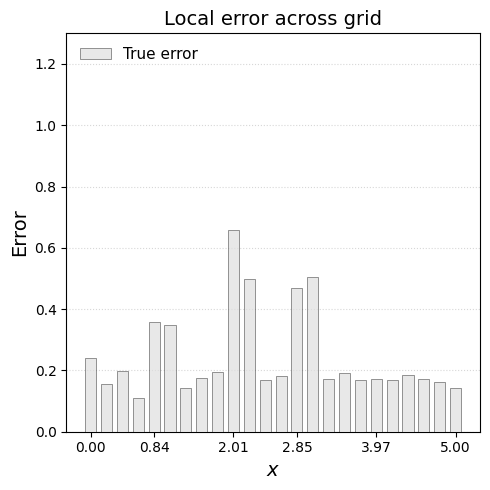

In [60]:
cp_cal_predset = cp_model.predict(
            alpha=0.05, X_test=X_test,
            **cp_pred_kwargs
            )
cp_width = (cp_cal_predset[1]-cp_cal_predset[0])

fig, ax = plot_local_error_bar(X_test, local_noise, 
                               k=5,
                               nbar=24,
                               colors=("#dfdfdf", "#4287f5"),
                               labels=("True error", "CP error"))
plt.show()

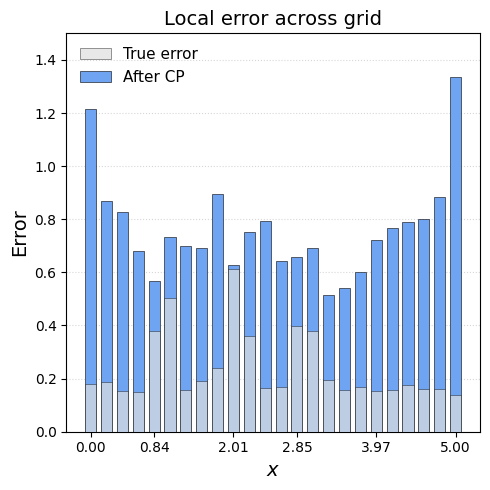

In [61]:
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":raw_heuristic,  # Change this based on cp
        "k":30
}

cp_cal_predset = cp_model.predict(
            alpha=0.05, X_test=X_test,
            **cp_pred_kwargs
            )
cp_width = (cp_cal_predset[1]-cp_cal_predset[0])

fig, ax = plot_local_error_bar(X_test, local_noise, 
                               heuristics=cp_width,
                               k=20,
                               nbar=24,
                               colors=("#dfdfdf", "#6ea4f1"),
                               labels=("True error", "After CP"),
                               ylim=(0, 1.5))
plt.show()

In [62]:
adap_cp = AdaptiveCP(uqmodel, alpha=0.05)

adap_cp_cal_predset = adap_cp.predict(
            alpha=0.05, X_test=X_test,
            **cp_pred_kwargs
            )
adap_cp_width = (adap_cp_cal_predset[1]-adap_cp_cal_predset[0])/2



[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


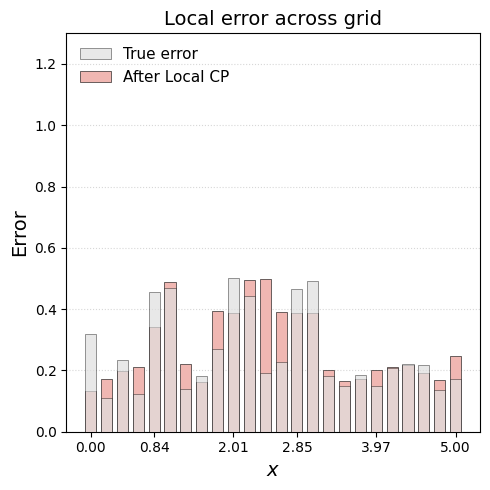

In [63]:

fig, ax = plot_local_error_bar(X_test, local_noise, 
                               heuristics=adap_cp_width,
                               k=1,
                               nbar=24,
                               colors=("#dfdfdf", "#f0b7b2"),
                               labels=("True error", "After Local CP"))
plt.show()

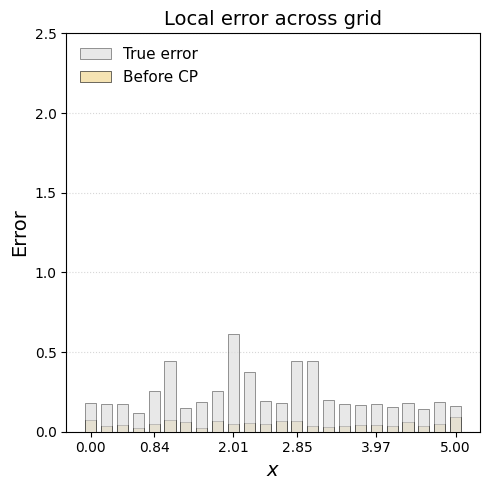

In [64]:
baseline_pred_kwargs = dict(n_samples=5, heuristic_u=raw_heuristic)
heu_predset = uqmodel.predict(alpha, X_test, 
                                   **baseline_pred_kwargs)
heu_width = (heu_predset[1]-heu_predset[0])/2

fig, ax = plot_local_error_bar(X_test, local_noise, 
                               heuristics=heu_width,
                               k=10,
                               nbar=24,
                               colors=("#dfdfdf", "#f5e3b3"),
                               labels=("True error", "Before CP"),
                               ylim=(0, 2.5))
plt.show()

In [70]:
# --- PATCH: add `ax` support to plot_local_error_bar (only changed parts marked) ---
import torch, numpy as np, matplotlib.pyplot as plt

@torch.no_grad()
def plot_local_error_bar(
    X: torch.Tensor,
    local_err: torch.Tensor,
    heuristics: torch.Tensor | None = None,   # optional
    *,
    k: int = 15,
    nbar: int | None = None,
    colors=("#d9534f", "#4287f5"),
    labels=("True", "Est."),
    bar_width: float = 0.7,
    overlay_frac: float = 1.0,
    figsize=(5, 5),
    title="Local error across grid",
    tick_count: int = 6,
    top_pad: float = 0.12,
    ylim: tuple[float, float] | None = (0, 1.3),
    est_alpha: float = 1.0,                  # slight transparency on heuristic
    edge_lw: float = 0.4,                     # edge line width
    e_alpha = 0.7,
    # NEW
    ax: plt.Axes | None = None,
):
    # ... (all your existing code up to "m = len(true_sorted)")
    Xc = X.detach().cpu()
    if Xc.ndim == 1:
        Xc = Xc.unsqueeze(-1)
    n = Xc.shape[0]
    k = int(max(1, min(k, n)))

    true_err = local_err.detach().cpu().reshape(-1)

    dists = torch.cdist(Xc, Xc, p=2)
    nn_idx = torch.topk(dists, k=k, dim=1, largest=False).indices

    true_knn = true_err[nn_idx].mean(dim=1).numpy()

    heur_knn = None
    if heuristics is not None:
        heur = heuristics.detach().cpu().reshape(-1)
        heur_knn = heur[nn_idx].mean(dim=1).numpy()

    x1d = X.detach().cpu().reshape(-1).numpy() if X.dim() == 1 or Xc.shape[1] == 1 else np.arange(n, dtype=float)
    order = np.argsort(x1d)
    x_sorted    = x1d[order]
    true_sorted = true_knn[order]
    heur_sorted = heur_knn[order] if heur_knn is not None else None

    if nbar is not None and nbar < len(true_sorted):
        idx = np.linspace(0, len(true_sorted)-1, nbar).astype(int)
        x_sorted    = x_sorted[idx]
        true_sorted = true_sorted[idx]
        if heur_sorted is not None:
            heur_sorted = heur_sorted[idx]

    m = len(true_sorted)
    pos = np.arange(m)

    # NEW: draw on provided axes (or make one if absent)
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    # base bars
    ax.bar(
        pos, true_sorted,
        width=bar_width,
        color=colors[0],
        edgecolor="black",
        linewidth=edge_lw,
        label=labels[0],
        zorder=4,
        alpha=e_alpha
    )

    # overlay bars (ensure actually ON TOP)
    if heur_sorted is not None:
        narrow_w = max(1e-3, min(bar_width, bar_width * overlay_frac))
        ax.bar(
            pos, heur_sorted,
            width=narrow_w,
            color=colors[1],
            edgecolor="black",
            linewidth=edge_lw,
            alpha=est_alpha,
            label=labels[1],
            zorder=3,  
        )

    ticks = np.linspace(0, m-1, min(tick_count, m)).astype(int)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{x_sorted[t]:.2f}" for t in ticks])

    ax.set_xlabel(r"$x$", fontsize=14)
    ax.set_ylabel("Error", fontsize=14)
    ax.yaxis.grid(True, linestyle=":", alpha=0.5, zorder=0)

    if ylim is not None:
        ax.set_ylim(*ylim)
    else:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax*(1+top_pad))

    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False, loc="upper left", fontsize=11)

    if created_fig:
        fig.tight_layout()

    return fig, ax


In [ ]:
# --- NEW: 2×2 grid wrapper that passes `ax=...` so bars appear in each panel ---
import matplotlib.pyplot as plt

def plot_local_error_grid_2x2(
    *,
    X_test: torch.Tensor,
    local_noise: torch.Tensor,
    cp_model,
    uqmodel,
    AdaptiveCP,
    cp_pred_kwargs: dict | None = None,
    baseline_pred_kwargs,
    raw_heuristic: torch.Tensor | None = None,
    alpha_cp_panel2: float = 0.15,
    alpha_local_cp: float = 0.05,
    alpha_baseline: float = 0.05,
    k = (20, 20, 20, 20),
    nbar = (24, 24, 30, 24),
    ylims = (None, (0, 1.5), None, (0, 2.5)),
    colors = (
        ("#dfdfdf", "#4287f5"),
        ("#dfdfdf", "#6ea4f1"),
        ("#dfdfdf", "#f0b7b2"),
        ("#dfdfdf", "#f5e3b3"),
    ),
    labels = (
        ("True error"),
        ("After CP"),
        ("After Local CP"),
        ("Before CP"),
    ),
    tick_count: int = 6,
    bar_width: float = 0.7,
    overlay_frac: float = 1.0,
    figsize=(12, 10),
    suptitle: str | None = "Local error vs. interval widths (2×2)",
    sharey: bool = False,
):
    if cp_pred_kwargs is None:
        cp_pred_kwargs = {}

    fig, axs = plt.subplots(2, 2, figsize=figsize, sharey=sharey)
    axs = axs.ravel()

    # (1) True error only
    plot_local_error_bar(
        X_test, local_noise,
        k=k[0], nbar=nbar[0],
        colors=colors[0], labels=labels[0],
        bar_width=bar_width, overlay_frac=overlay_frac,
        tick_count=tick_count, ylim=ylims[0],
        title="True error",
        ax=axs[0],
    )

    # (2) CP vs True
    cp_pred = cp_model.predict(alpha=alpha_cp_panel2, X_test=X_test, **cp_pred_kwargs)
    cp_width = (cp_pred[1] - cp_pred[0])
    plot_local_error_bar(
        X_test, local_noise,
        heuristics=cp_width,
        k=k[1], nbar=nbar[1],
        colors=colors[1], labels=labels[1],
        bar_width=bar_width, overlay_frac=overlay_frac,
        tick_count=tick_count, ylim=ylims[1],
        title=f"CP vs True (α={alpha_cp_panel2:.2f})",
        ax=axs[1],
    )

    # (3) Local CP vs True
    adap_cp = AdaptiveCP(uqmodel, alpha=alpha_local_cp)
    adap_pred = adap_cp.predict(alpha=alpha_local_cp, X_test=X_test, **cp_pred_kwargs)
    adap_width = (adap_pred[1] - adap_pred[0]) / 2.0
    plot_local_error_bar(
        X_test, local_noise,
        heuristics=adap_width,
        k=k[2], nbar=nbar[2],
        colors=colors[2], labels=labels[2],
        bar_width=bar_width, overlay_frac=overlay_frac,
        tick_count=tick_count, ylim=ylims[2],
        title=f"Local CP vs True (α={alpha_local_cp:.2f})",
        ax=axs[2],
    )

    # (4) Heuristic vs True
    heu_pred = uqmodel.predict(alpha_baseline, X_test, **baseline_pred_kwargs)
    heu_width = (heu_pred[1] - heu_pred[0]) / 2.0
    plot_local_error_bar(
        X_test, local_noise,
        heuristics=heu_width,
        k=k[3], nbar=nbar[3],
        colors=colors[3], labels=labels[3],
        bar_width=bar_width, overlay_frac=overlay_frac,
        tick_count=tick_count, ylim=ylims[3],
        title=f"Heuristic vs True (α={alpha_baseline:.2f})",
        ax=axs[3],
    )

    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    fig.tight_layout(rect=(0, 0, 1, 0.96) if suptitle else None)
    return fig, axs



[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


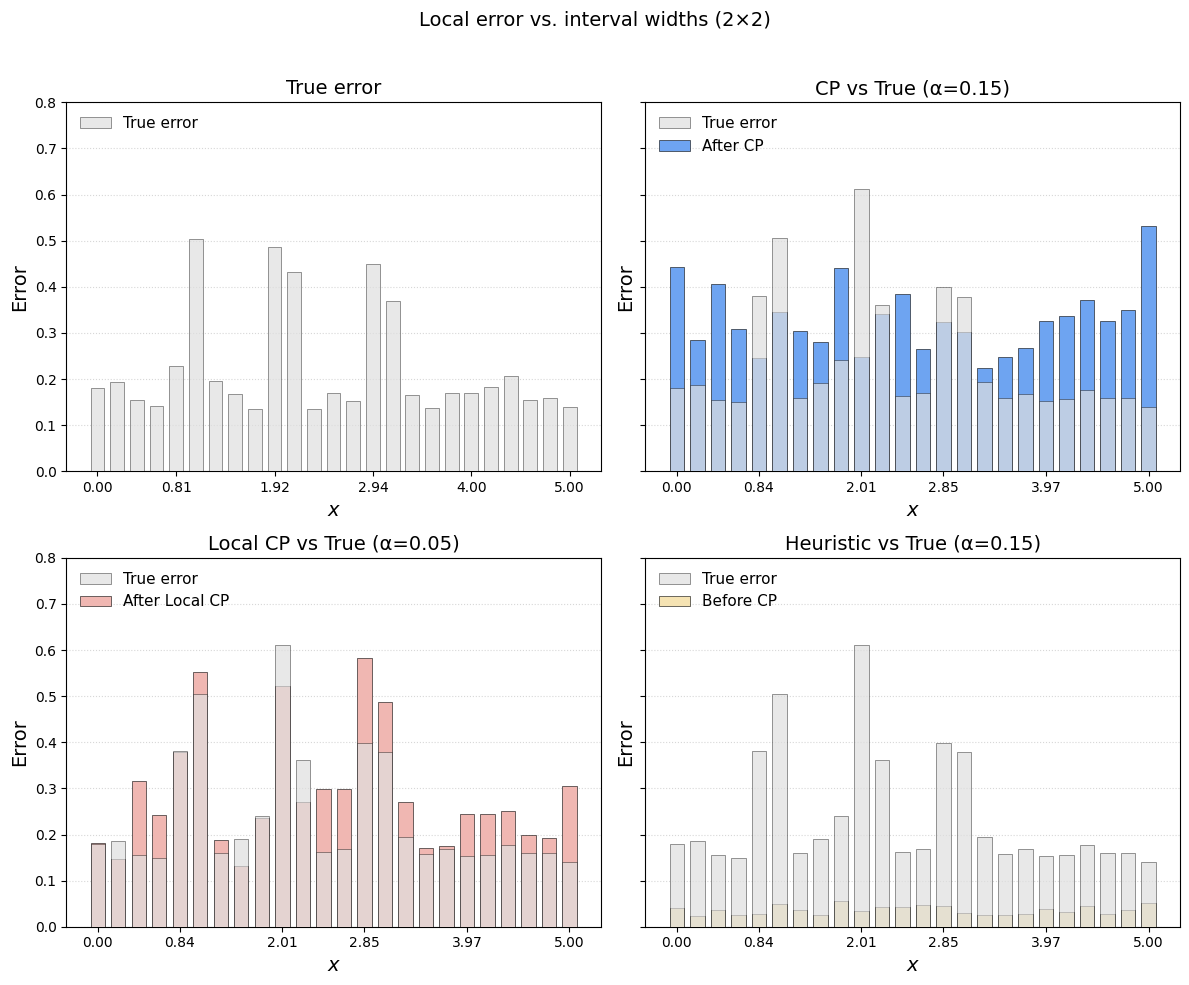

In [81]:
alpha = 0.05

cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":raw_heuristic,  # Change this based on cp
        "k":20
}

baseline_pred_kwargs = dict(n_samples=5, heuristic_u=raw_heuristic)

fig, axs = plot_local_error_grid_2x2(
    X_test=X_test,
    local_noise=local_noise,
    cp_model=cp_model,
    uqmodel=uqmodel,
    AdaptiveCP=AdaptiveCP,
    cp_pred_kwargs=cp_pred_kwargs,
    baseline_pred_kwargs=baseline_pred_kwargs,
    raw_heuristic=raw_heuristic,
    sharey=True,   # optional same y-scale
    ylims = ((0, 0.8),(0, 0.8),(0, 0.8),(0, 0.8)),
    alpha_cp_panel2 = 0.15,
    alpha_local_cp = 0.05,
    alpha_baseline = 0.15,
    nbar=(24,24,24,24)
)
plt.show()
